In [168]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [169]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


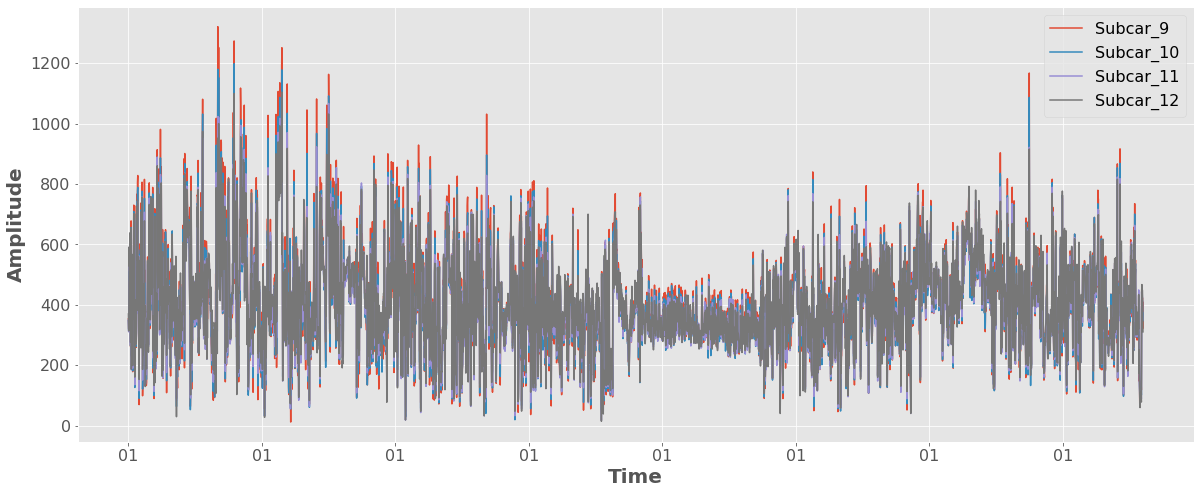

In [170]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
# plt.savefig('../images/raw_minMax.png', dpi=500)


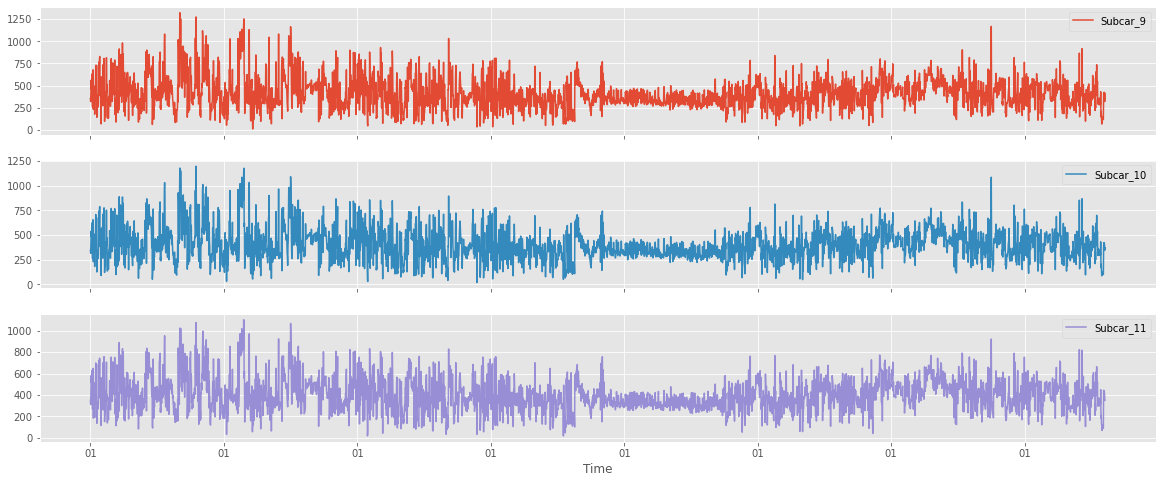

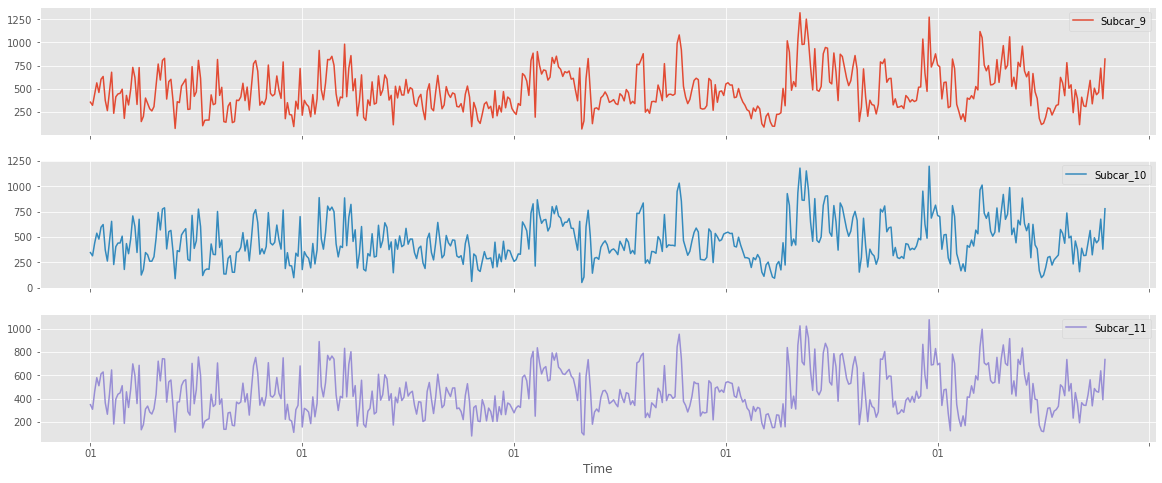

In [171]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11' ]
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_minMax_1.pdf', dpi=500)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)
# plt.savefig('../images/raw_minMax_2.pdf', dpi=500)


In [172]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [173]:
df_input = data_2[['Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12', ]]
df_input.head()


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
Time,,,,
1970-01-01 00:00:01.641598542,353.793725,347.315419,349.905702,369.545667
1970-01-01 00:00:01.641598543,319.820262,315.317300,310.386855,313.359219
1970-01-01 00:00:01.641598544,441.279957,441.367194,461.677376,465.649009
1970-01-01 00:00:01.641598545,562.694411,538.674299,580.400724,591.622346
1970-01-01 00:00:01.641598546,458.423385,479.883319,511.391240,527.319637


In [174]:
df_input.describe()


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
count,3802.000000,3802.000000,3802.000000,3802.000000
mean,410.627681,403.013887,401.351757,409.075167
std,171.775869,160.406865,152.042491,149.184960
min,11.661904,19.235384,17.029386,14.317821
25%,301.906856,299.537560,302.426850,310.169711
50%,387.431284,381.450521,381.629371,392.020408
75%,496.494461,487.182967,486.122154,497.416318
max,1320.984860,1198.269586,1101.918781,1104.339169


In [175]:
df_input.query("Subcar_9 > 500")


,Subcar_9,Subcar_10,Subcar_11,Subcar_12
Time,,,,
1970-01-01 00:00:01.641598545,562.694411,538.674299,580.400724,591.622346
1970-01-01 00:00:01.641598547,601.239553,597.501464,612.315278,607.217424
1970-01-01 00:00:01.641598547,631.708794,623.773196,629.221742,638.401128
1970-01-01 00:00:01.641598550,677.784627,655.331977,646.693900,654.083328
1970-01-01 00:00:01.641598556,730.010959,708.801806,698.401747,700.925103
...,...,...,...,...
1970-01-01 00:00:01.641600103,656.966514,620.133050,616.235345,615.601332
1970-01-01 00:00:01.641600104,533.258849,523.495941,529.429882,522.215473
1970-01-01 00:00:01.641600105,734.908158,700.594034,663.127439,645.600496


In [176]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[0.26130438, 0.27826168, 0.30682973, 0.32589072],
       [0.23535703, 0.25112242, 0.27040311, 0.27434453],
       [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
       ...,
       [0.31431976, 0.33538326, 0.37370201, 0.39796507],
       [0.23619976, 0.27684802, 0.32360963, 0.35399159],
       [0.30271959, 0.30005974, 0.3069601 , 0.2715127 ]])

In [177]:
# features are inputs as well as ta
# target value is index 2

features = data_scaled
target = data_scaled[:, 0]


In [178]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[0]


(array([[[0.26130438, 0.27826168, 0.30682973, 0.32589072],
         [0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         [0.34121565, 0.39069938, 0.4556795 , 0.47063465],
         [0.450292  , 0.49045743, 0.54870653, 0.54393394]]]),
 array([0.47356299]))

In [179]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False) # false for timeseries
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 4)
X_test.shape:  (761, 4)


In [180]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [181]:
train_generator[0]


(array([[[0.26130438, 0.27826168, 0.30682973, 0.32589072],
         [0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         ...,
         [0.27835589, 0.30253303, 0.3397856 , 0.35555178],
         [0.31792614, 0.36768943, 0.39365483, 0.4225886 ],
         [0.07417749, 0.10961531, 0.14609373, 0.20045649]],
 
        [[0.23535703, 0.25112242, 0.27040311, 0.27434453],
         [0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         ...,
         [0.31792614, 0.36768943, 0.39365483, 0.4225886 ],
         [0.07417749, 0.10961531, 0.14609373, 0.20045649],
         [0.3926685 , 0.38698947, 0.36624711, 0.3495528 ]],
 
        [[0.32812229, 0.35803186, 0.4098556 , 0.4140572 ],
         [0.42085301, 0.44056306, 0.51928919, 0.52962681],
         [0.34121565, 0.39069938, 0.4556795 , 0.47063465],
         ...,
         [0.07417749, 0.10961531, 0.14609373, 0.20045649],
        

In [182]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

lstm_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 144, 128)          68096     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 128)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)              

In [183]:
cp1 = ModelCheckpoint('../save/lstm_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}

In [184]:
history = lstm_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/20
91/91 [==============================] - 24s 261ms/step - loss: 0.0200 - mean_absolute_error: 0.1048 - val_loss: 0.0124 - val_mean_absolute_error: 0.0870
Epoch 2/20
91/91 [==============================] - 24s 266ms/step - loss: 0.0172 - mean_absolute_error: 0.0974 - val_loss: 0.0119 - val_mean_absolute_error: 0.0848
Epoch 3/20
91/91 [==============================] - 16s 172ms/step - loss: 0.0169 - mean_absolute_error: 0.0962 - val_loss: 0.0119 - val_mean_absolute_error: 0.0852
Epoch 4/20
91/91 [==============================] - 16s 171ms/step - loss: 0.0165 - mean_absolute_error: 0.0954 - val_loss: 0.0121 - val_mean_absolute_error: 0.0862


In [185]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 6s 63ms/step - loss: 0.0161 - mean_absolute_error: 0.0983


In [186]:
predictions_lstm = lstm_model.predict(test_generator)


In [187]:
from tensorflow.keras.models import load_model
lstm_model = load_model('../save/lstm_model/')

In [188]:
predictions_lstm.shape[0]


617

In [189]:
predictions_lstm


array([[0.37725803],
       [0.37832907],
       [0.38576433],
       [0.3955001 ],
       [0.40591493],
       [0.41006574],
       [0.4072407 ],
       [0.40143773],
       [0.3975084 ],
       [0.39555776],
       [0.39282706],
       [0.39149186],
       [0.39256153],
       [0.3906481 ],
       [0.3833142 ],
       [0.37383467],
       [0.36574128],
       [0.36287543],
       [0.3655874 ],
       [0.36831608],
       [0.3714005 ],
       [0.37223324],
       [0.3703647 ],
       [0.36489907],
       [0.35817423],
       [0.35384813],
       [0.34802285],
       [0.34241748],
       [0.33803305],
       [0.33635935],
       [0.3369502 ],
       [0.33908543],
       [0.34201434],
       [0.3459541 ],
       [0.35039926],
       [0.3551242 ],
       [0.35690507],
       [0.35578635],
       [0.35480556],
       [0.35297135],
       [0.3513416 ],
       [0.35102823],
       [0.3519506 ],
       [0.35250488],
       [0.3533179 ],
       [0.35179317],
       [0.35270032],
       [0.358

In [190]:
y_test


array([0.29244596, 0.35198348, 0.36175921, 0.26042866, 0.26189846,
       0.26844404, 0.2585389 , 0.26306772, 0.26910365, 0.15445075,
       0.20390649, 0.40778704, 0.2098589 , 0.24497661, 0.37471418,
       0.38316737, 0.30191834, 0.41769515, 0.45070593, 0.30268402,
       0.29910845, 0.3127504 , 0.30809781, 0.46128071, 0.36794034,
       0.24092465, 0.3254899 , 0.40493554, 0.21435232, 0.21615567,
       0.26014697, 0.19296986, 0.24487665, 0.24012953, 0.26434728,
       0.25594061, 0.28710063, 0.27910219, 0.37221842, 0.36795814,
       0.30391901, 0.29633193, 0.21252638, 0.27566286, 0.39902407,
       0.36583474, 0.33969039, 0.25207793, 0.50439293, 0.13618625,
       0.36321753, 0.24808233, 0.34548221, 0.36566347, 0.36241015,
       0.36621746, 0.36942802, 0.40355755, 0.36556613, 0.34661367,
       0.33419791, 0.32123441, 0.44341197, 0.41348685, 0.24182079,
       0.48050664, 0.25930227, 0.40598852, 0.28602468, 0.31392611,
       0.29714113, 0.24956479, 0.32762086, 0.33385517, 0.33024

In [191]:
x_test


array([[0.29244596, 0.3134606 , 0.34584301, 0.3502124 ],
       [0.35198348, 0.37667641, 0.4106156 , 0.43122044],
       [0.36175921, 0.38586061, 0.4290162 , 0.43823661],
       ...,
       [0.31431976, 0.33538326, 0.37370201, 0.39796507],
       [0.23619976, 0.27684802, 0.32360963, 0.35399159],
       [0.30271959, 0.30005974, 0.3069601 , 0.2715127 ]])

In [192]:
x_test[:, 1:][win_length:]


array([[0.49814461, 0.55270415, 0.5586457 ],
       [0.60819308, 0.62967567, 0.67045016],
       [0.5346585 , 0.59670373, 0.61118574],
       ...,
       [0.33538326, 0.37370201, 0.39796507],
       [0.27684802, 0.32360963, 0.35399159],
       [0.30005974, 0.3069601 , 0.2715127 ]])

In [193]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2
0,0.377258,0.498145,0.552704,0.558646
1,0.378329,0.608193,0.629676,0.670450
2,0.385764,0.534658,0.596704,0.611186
3,0.395500,0.564733,0.613395,0.630380
4,0.405915,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.241563,0.343359,0.369597,0.415296
613,0.256924,0.333923,0.388717,0.399705
614,0.276935,0.335383,0.373702,0.397965
615,0.297393,0.276848,0.323610,0.353992


In [194]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[505.61450624, 606.5649182 , 616.6522521 , 623.25356   ],
       [507.01683808, 736.315829  , 700.1578393 , 745.1228087 ],
       [516.75199756, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [374.25903714, 414.6637192 , 422.4547313 , 448.1082459 ],
       [401.04588534, 345.6486656 , 368.1100379 , 400.1762112 ],
       [421.81212626, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [195]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]

In [196]:
df_final_lstm.count()


Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_12    617
dtype: int64

In [197]:
df_final_lstm['Subcar_9_pred'] = rev_trans[:, 0]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,505.614506
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,507.016838
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,516.751998
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,529.499256
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,543.135643
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,327.945641
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,348.058985
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,374.259037


In [198]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [199]:
cp3 = ModelCheckpoint('../save/gru_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [200]:
history_2 = gru_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/20
91/91 [==============================] - 33s 362ms/step - loss: 0.0179 - mean_absolute_error: 0.0975 - val_loss: 0.0113 - val_mean_absolute_error: 0.0824
Epoch 2/20
91/91 [==============================] - 31s 346ms/step - loss: 0.0140 - mean_absolute_error: 0.0868 - val_loss: 0.0112 - val_mean_absolute_error: 0.0818
Epoch 3/20
91/91 [==============================] - 15s 163ms/step - loss: 0.0136 - mean_absolute_error: 0.0852 - val_loss: 0.0112 - val_mean_absolute_error: 0.0821
Epoch 4/20
91/91 [==============================] - 15s 161ms/step - loss: 0.0134 - mean_absolute_error: 0.0844 - val_loss: 0.0112 - val_mean_absolute_error: 0.0819


In [201]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model/')

In [202]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = gru_model.evaluate(train_generator)
performance['BiLSTM'] = gru_model.evaluate(test_generator, verbose=0)

91/91 [==============================] - 11s 122ms/step - loss: 0.0140 - mean_absolute_error: 0.0895


In [203]:
predictions_gru = gru_model.predict(test_generator)


In [204]:
predictions_gru.shape[0]


617

In [205]:
predictions_gru


array([[0.39926633],
       [0.4118644 ],
       [0.436356  ],
       [0.44503054],
       [0.45679498],
       [0.43934882],
       [0.42115518],
       [0.41514394],
       [0.42321566],
       [0.42571604],
       [0.41728133],
       [0.42202   ],
       [0.42801738],
       [0.41104794],
       [0.38590753],
       [0.37342492],
       [0.37083364],
       [0.38411635],
       [0.3975225 ],
       [0.38951272],
       [0.3931281 ],
       [0.38502967],
       [0.37622684],
       [0.3603232 ],
       [0.35144177],
       [0.35733655],
       [0.34016877],
       [0.33468574],
       [0.33099383],
       [0.336834  ],
       [0.34092382],
       [0.34446454],
       [0.3486182 ],
       [0.35596687],
       [0.3622858 ],
       [0.3688724 ],
       [0.3608182 ],
       [0.35461652],
       [0.36023265],
       [0.3550926 ],
       [0.3552783 ],
       [0.35950252],
       [0.36346388],
       [0.36235464],
       [0.36567882],
       [0.35396197],
       [0.3674242 ],
       [0.388

In [206]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru


,0,0,1,2
0,0.399266,0.498145,0.552704,0.558646
1,0.411864,0.608193,0.629676,0.670450
2,0.436356,0.534658,0.596704,0.611186
3,0.445031,0.564733,0.613395,0.630380
4,0.456795,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.212124,0.343359,0.369597,0.415296
613,0.248384,0.333923,0.388717,0.399705
614,0.274638,0.335383,0.373702,0.397965
615,0.292988,0.276848,0.323610,0.353992


In [207]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[534.43047843, 606.5649182 , 616.6522521 , 623.25356   ],
       [550.92541744, 736.315829  , 700.1578393 , 745.1228087 ],
       [582.99284221, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [371.25130888, 414.6637192 , 422.4547313 , 448.1082459 ],
       [395.27762599, 345.6486656 , 368.1100379 , 400.1762112 ],
       [399.17783948, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [208]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]


In [209]:
df_final_gru['Subcar_9_pred'] = rev_trans[:, 0]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,534.430478
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,550.925417
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,582.992842
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,594.350606
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,609.754054
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,289.401065
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,336.877166
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,371.251309


In [210]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [211]:
cp4 = ModelCheckpoint('../save/conv_model/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [212]:
history_3 = conv_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0249 - mean_absolute_error: 0.1137 - val_loss: 0.0138 - val_mean_absolute_error: 0.0921
Epoch 2/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0185 - mean_absolute_error: 0.1001 - val_loss: 0.0130 - val_mean_absolute_error: 0.0897
Epoch 3/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0176 - mean_absolute_error: 0.0992 - val_loss: 0.0126 - val_mean_absolute_error: 0.0883
Epoch 4/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0175 - mean_absolute_error: 0.0989 - val_loss: 0.0125 - val_mean_absolute_error: 0.0881
Epoch 5/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0175 - mean_absolute_error: 0.0988 - val_loss: 0.0125 - val_mean_absolute_error: 0.0879
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 0.0175 - mean_absolute_error: 0.0988 - val_loss: 0.0124 - val_mean_absolute_error: 0.0876
Epoch 7/20
91/91 [==========

In [213]:
from tensorflow.keras.models import load_model
conv_model = load_model('../save/conv_model/')


In [214]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = conv_model.evaluate(train_generator)
performance['CONV'] = conv_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 0s 1ms/step - loss: 0.0183 - mean_absolute_error: 0.1009


In [215]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv


array([[[0.29877415],
        [0.30041972],
        [0.30280688],
        ...,
        [0.3021178 ],
        [0.30088115],
        [0.3009082 ]],

       [[0.30041972],
        [0.30280688],
        [0.30073193],
        ...,
        [0.30088115],
        [0.3009082 ],
        [0.29945716]],

       [[0.30280688],
        [0.30073193],
        [0.30150205],
        ...,
        [0.3009082 ],
        [0.29945716],
        [0.2970555 ]],

       ...,

       [[0.30020645],
        [0.29562852],
        [0.30094126],
        ...,
        [0.30410823],
        [0.3018817 ],
        [0.3029854 ]],

       [[0.29562852],
        [0.30094126],
        [0.30183524],
        ...,
        [0.3018817 ],
        [0.3029854 ],
        [0.30258092]],

       [[0.30094126],
        [0.30183524],
        [0.3016879 ],
        ...,
        [0.3029854 ],
        [0.3025809 ],
        [0.30328965]]], dtype=float32)

In [216]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2
0,0.399266,0.498145,0.552704,0.558646
1,0.411864,0.608193,0.629676,0.670450
2,0.436356,0.534658,0.596704,0.611186
3,0.445031,0.564733,0.613395,0.630380
4,0.456795,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.212124,0.343359,0.369597,0.415296
613,0.248384,0.333923,0.388717,0.399705
614,0.274638,0.335383,0.373702,0.397965
615,0.292988,0.276848,0.323610,0.353992


In [217]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[534.43047843, 606.5649182 , 616.6522521 , 623.25356   ],
       [550.92541744, 736.315829  , 700.1578393 , 745.1228087 ],
       [582.99284221, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [371.25130888, 414.6637192 , 422.4547313 , 448.1082459 ],
       [395.27762599, 345.6486656 , 368.1100379 , 400.1762112 ],
       [399.17783948, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [218]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]

In [219]:
df_final_conv['Subcar_9_pred'] = rev_trans_conv[:, 0]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,534.430478
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,550.925417
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,582.992842
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,594.350606
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,609.754054
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,289.401065
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,336.877166
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,371.251309


In [220]:
gr_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(win_length, num_features), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, 'relu'),
    tf.keras.layers.Dense(1, 'linear'),
])

gr_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 144, 128)          51456     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 63,873
Trainable params: 63,873
Non-trainable params: 0
_________________________________________________________________


In [221]:
cp5 = ModelCheckpoint('../save/gru_model_real', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gr_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [222]:
history_4 = gr_model.fit(
    train_generator, epochs=20,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp5])


Epoch 1/20
91/91 [==============================] - 10s 110ms/step - loss: 0.0170 - mean_absolute_error: 0.0930 - val_loss: 0.0104 - val_mean_absolute_error: 0.0775
Epoch 2/20
91/91 [==============================] - 7s 72ms/step - loss: 0.0131 - mean_absolute_error: 0.0830 - val_loss: 0.0108 - val_mean_absolute_error: 0.0792
Epoch 3/20
91/91 [==============================] - 9s 103ms/step - loss: 0.0131 - mean_absolute_error: 0.0830 - val_loss: 0.0103 - val_mean_absolute_error: 0.0768
Epoch 4/20
91/91 [==============================] - 6s 71ms/step - loss: 0.0131 - mean_absolute_error: 0.0830 - val_loss: 0.0106 - val_mean_absolute_error: 0.0783
Epoch 5/20
91/91 [==============================] - 6s 70ms/step - loss: 0.0130 - mean_absolute_error: 0.0827 - val_loss: 0.0104 - val_mean_absolute_error: 0.0775


In [223]:
from tensorflow.keras.models import load_model
gr_model = load_model('../save/gru_model_real/')

In [224]:
gr_eval = gr_model.evaluate(
    test_generator, verbose=0
)
gr_eval
val_performance['GRU'] = gr_model.evaluate(train_generator)
performance['GRU'] = gr_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 2s 21ms/step - loss: 0.0131 - mean_absolute_error: 0.0847


In [225]:
predictions_gr = gr_model.predict(test_generator)
predictions_gr


array([[0.3901206 ],
       [0.41049853],
       [0.44352672],
       [0.43792728],
       [0.45074487],
       [0.40830082],
       [0.3890951 ],
       [0.39684504],
       [0.41800192],
       [0.4162207 ],
       [0.39601347],
       [0.41246828],
       [0.42154756],
       [0.37924495],
       [0.34914598],
       [0.35110414],
       [0.35678682],
       [0.38328657],
       [0.39820063],
       [0.37085667],
       [0.38339397],
       [0.36363542],
       [0.35368165],
       [0.3335566 ],
       [0.3344568 ],
       [0.35636997],
       [0.31425464],
       [0.32046935],
       [0.3202817 ],
       [0.32941285],
       [0.33253467],
       [0.33568802],
       [0.33888677],
       [0.34840226],
       [0.35265282],
       [0.35931954],
       [0.33800682],
       [0.3334062 ],
       [0.35101613],
       [0.33636782],
       [0.34269503],
       [0.35055465],
       [0.35192698],
       [0.3432699 ],
       [0.35092303],
       [0.32757127],
       [0.3630469 ],
       [0.390

In [226]:
df_pred_gr = pd.concat([pd.DataFrame(predictions_gr),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gr


,0,0,1,2
0,0.390121,0.498145,0.552704,0.558646
1,0.410499,0.608193,0.629676,0.670450
2,0.443527,0.534658,0.596704,0.611186
3,0.437927,0.564733,0.613395,0.630380
4,0.450745,0.416187,0.471090,0.483694
...,...,...,...,...
612,0.224055,0.343359,0.369597,0.415296
613,0.263178,0.333923,0.388717,0.399705
614,0.290492,0.335383,0.373702,0.397965
615,0.303331,0.276848,0.323610,0.353992


In [227]:
# To the original format
rev_trans_gr = scaler.inverse_transform(df_pred_gr)
rev_trans_gr


array([[522.45575542, 606.5649182 , 616.6522521 , 623.25356   ],
       [549.13705218, 736.315829  , 700.1578393 , 745.1228087 ],
       [592.38161348, 649.6160404 , 664.3869355 , 680.523328  ],
       ...,
       [392.00931639, 414.6637192 , 422.4547313 , 448.1082459 ],
       [408.82005126, 345.6486656 , 368.1100379 , 400.1762112 ],
       [391.31314514, 373.0160854 , 350.0471397 , 310.2724609 ]])

In [228]:
df_final_gr = df_input[predictions_gr.shape[0]*-1:]


In [229]:
df_final_gr['Subcar_9_pred'] = rev_trans_gr[:, 0]
df_final_gr


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_9,Subcar_10,Subcar_11,Subcar_12,Subcar_9_pred
Time,,,,,
1970-01-01 00:00:01.641599862,620.762434,606.564918,616.652252,623.253560,522.455755
1970-01-01 00:00:01.641599862,693.411855,736.315829,700.157839,745.122809,549.137052
1970-01-01 00:00:01.641599862,658.145880,649.616040,664.386936,680.523328,592.381613
1970-01-01 00:00:01.641599862,687.278692,685.075178,682.495421,701.445650,585.050139
1970-01-01 00:00:01.641599862,524.756134,509.934309,528.109837,541.554245,601.832506
...,...,...,...,...,...
1970-01-01 00:00:01.641600115,424.067212,424.067212,418.001196,466.998929,305.021741
1970-01-01 00:00:01.641600115,404.853060,412.941885,438.744800,450.004444,356.246733
1970-01-01 00:00:01.641600115,423.207987,414.663719,422.454731,448.108246,392.009316


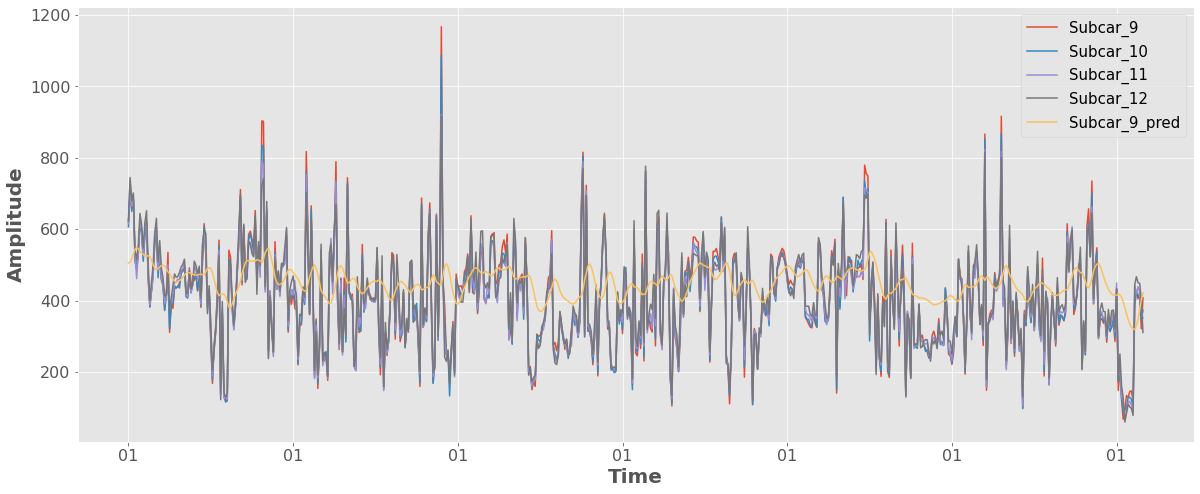

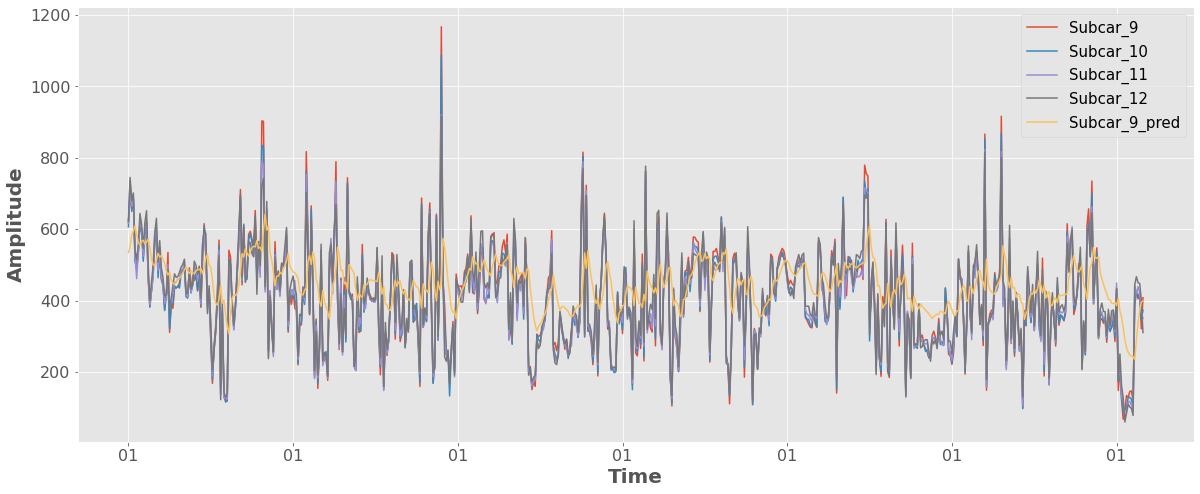

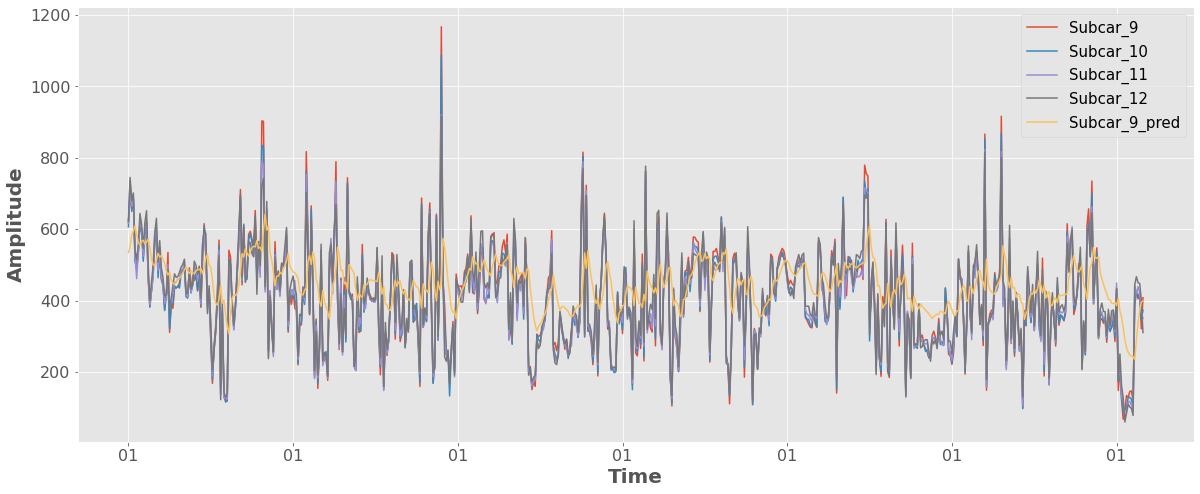

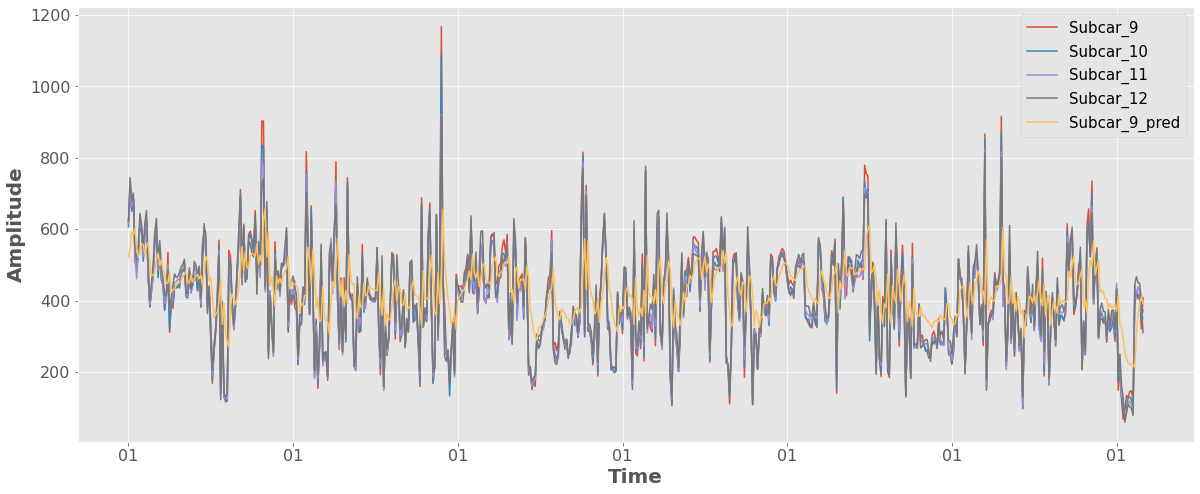

In [230]:
df_final_lstm[['Subcar_9', 'Subcar_9_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/lstm_curve.png', dpi=120)

df_final_gru[['Subcar_9', 'Subcar_9_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/bilstm_curve.png', dpi=120)

df_final_conv[['Subcar_9', 'Subcar_9_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/conv_curve.png', dpi=120)


df_final_gr[['Subcar_9', 'Subcar_9_pred']]
df_final_gr.index = date_time[:617]
_ = df_final_gr.plot(subplots=False)
plt.ylabel("Amplitude", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xlabel("Time", fontsize=20, fontweight='bold',
           horizontalalignment='center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=15)
# plt.savefig('../images/gru_curve.png', dpi=120)


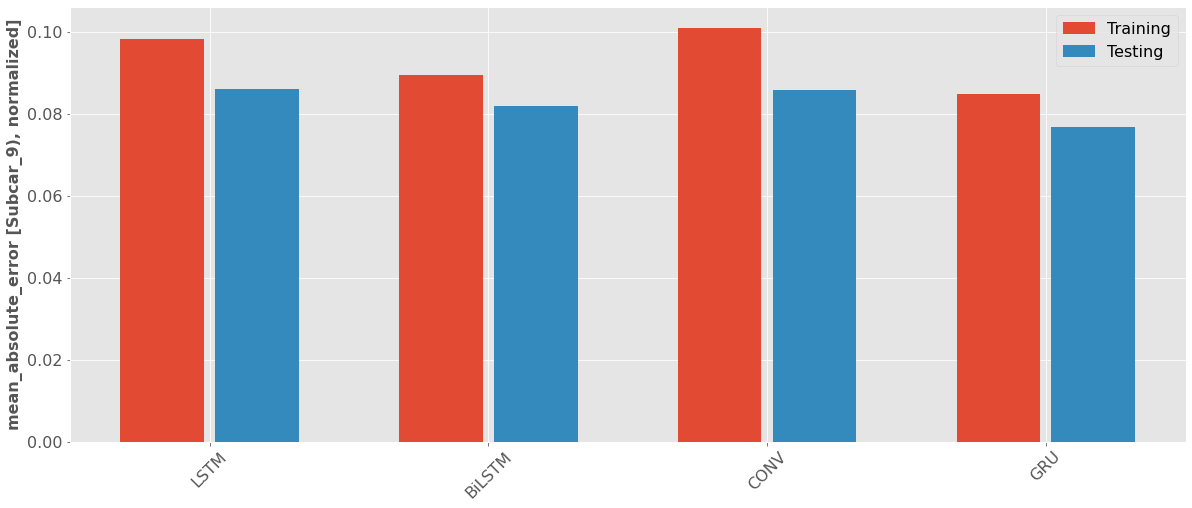

In [231]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_9), normalized]',
           fontsize=16, fontweight='bold', horizontalalignment='center')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45, fontsize=16)
plt.yticks(fontsize=16)
_ = plt.legend(fontsize=16)
# plt.savefig('../images/bar_graph.png', dpi=120)


In [232]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.0862
BiLSTM      : 0.0818
CONV        : 0.0859
GRU         : 0.0768


In [233]:
for name, value in val_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.0983
BiLSTM      : 0.0895
CONV        : 0.1009
GRU         : 0.0847
